# clustered CNN

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from datetime import datetime

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Current timestamp
timestamp = datetime(2025, 9, 16, 20, 21).strftime("%Y-%m-%d_%H-%M")

# Configuration
spectrogram_dir = "/kaggle/input/spectograms"
input_shape = (64, 64, 1)
n_clusters = 10
cluster_weight = 0.3  # Weight for cluster loss

# =====================================
# 1. Data Loading & Preprocessing
# =====================================
def load_process_image(path):
    img = plt.imread(path)
    if len(img.shape) == 3:
        img = np.mean(img, axis=-1)
    img = np.expand_dims(img, axis=-1)
    img = tf.image.resize(img, [64, 64]).numpy()
    return (img - img.mean()) / (img.std() + 1e-10)

# Load images and labels
image_paths, labels = [], []
for root, _, files in os.walk(spectrogram_dir):
    label = os.path.basename(root)
    if label == os.path.basename(spectrogram_dir):
        continue
    for f in files:
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, f))
            labels.append(label)

# Encode labels
le = LabelEncoder()
Y = le.fit_transform(labels)
Y_cat = tf.keras.utils.to_categorical(Y)
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")
print(f"Class names: {le.classes_}")

# Load and process all images
X = np.array([load_process_image(p) for p in image_paths])
print(f"X shape: {X.shape}, Y_cat shape: {Y_cat.shape}")

# Stratified train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_cat, test_size=0.2, stratify=Y, random_state=42
)
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

# Compute class counts for training set
Y_train_labels = np.argmax(Y_train, axis=1)
class_counts = np.bincount(Y_train_labels).tolist()
print(f"Class counts in training set: {class_counts}")

# =====================================
# Enhanced Data Augmentation for Spectrograms (for balancing)
# =====================================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.1, fill_mode='constant', fill_value=0.0),
])

def spec_augment(x, max_time_mask=10, max_freq_mask=10, num_time_masks=2, num_freq_masks=2):
    x = tf.convert_to_tensor(x)
    _, height, width, channels = x.shape
    for _ in range(num_time_masks):
        t = tf.random.uniform([], 0, max_time_mask, dtype=tf.int32)
        t0 = tf.random.uniform([], 0, width - t, dtype=tf.int32)
        x = tf.concat([
            x[:, :, :t0, :],
            tf.zeros([tf.shape(x)[0], height, t, channels]),
            x[:, :, t0+t:, :]
        ], axis=2)
    for _ in range(num_freq_masks):
        f = tf.random.uniform([], 0, max_freq_mask, dtype=tf.int32)
        f0 = tf.random.uniform([], 0, height - f, dtype=tf.int32)
        x = tf.concat([
            x[:, :f0, :, :],
            tf.zeros([tf.shape(x)[0], f, width, channels]),
            x[:, f0+f:, :, :]
        ], axis=1)
    return x

def augment_data(X, Y, class_counts, augment_factors):
    X_aug, Y_aug = [], []
    y_labels = np.argmax(Y, axis=1)
    print(f"Augment factors: {augment_factors}")
    print(f"Unique class indices in y_labels: {np.unique(y_labels)}")
    
    for i in range(len(X)):
        X_aug.append(X[i])
        Y_aug.append(Y[i])
        class_idx = y_labels[i]
        factor = augment_factors[class_idx]
        for _ in range(factor - 1):
            aug_img = data_augmentation(X[i:i+1])[0].numpy()
            aug_img = spec_augment(aug_img[None, ...], max_time_mask=10, max_freq_mask=10)[0].numpy()
            X_aug.append(aug_img)
            Y_aug.append(Y[i])
    
    return np.array(X_aug), np.array(Y_aug)

# Compute augmentation factors
max_count = max(class_counts)
augment_factors = [max(1, int(max_count / count)) for count in class_counts]
X_train_aug, Y_train_aug = augment_data(X_train, Y_train, class_counts, augment_factors)
print(f"X_train_aug shape: {X_train_aug.shape}, Y_train_aug shape: {Y_train_aug.shape}")

# Verify class counts after augmentation
Y_train_aug_labels = np.argmax(Y_train_aug, axis=1)
augmented_class_counts = np.bincount(Y_train_aug_labels).tolist()
print(f"Class counts after augmentation: {augmented_class_counts}")

# =====================================
# 2. K-means Clustering on Balanced Train Set
# =====================================
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
train_features_aug = X_train_aug.reshape(X_train_aug.shape[0], -1)
cluster_train = kmeans.fit_predict(train_features_aug)
cluster_test = kmeans.predict(X_test.reshape(X_test.shape[0], -1))

# Verify number of clusters
unique_clusters_train = len(np.unique(cluster_train))
print(f"Number of clusters in training set: {unique_clusters_train}")
if unique_clusters_train < n_clusters:
    print(f"Warning: KMeans produced {unique_clusters_train} clusters instead of {n_clusters}. Adjusting n_clusters.")
    n_clusters = unique_clusters_train
    cluster_train_cat = tf.keras.utils.to_categorical(cluster_train, num_classes=n_clusters)
    cluster_test_cat = tf.keras.utils.to_categorical(cluster_test, num_classes=n_clusters)
else:
    cluster_train_cat = tf.keras.utils.to_categorical(cluster_train)
    cluster_test_cat = tf.keras.utils.to_categorical(cluster_test)

print(f"cluster_train_cat shape: {cluster_train_cat.shape}, cluster_test_cat shape: {cluster_test_cat.shape}")

# =====================================
# 3. Clustered CNN Model
# =====================================
def build_clustered_cnn():
    inputs = layers.Input(shape=input_shape)
    
    # Shared Feature Extractor
    x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    features = layers.Flatten()(x)
    
    # Dual Outputs
    class_out = layers.Dense(num_classes, activation='softmax', name='class')(features)
    cluster_out = layers.Dense(n_clusters, activation='softmax', name='cluster')(features)
    
    return Model(inputs=inputs, outputs=[class_out, cluster_out])

model = build_clustered_cnn()

# =====================================
# 4. Data Pipeline
# =====================================
def create_dataset(X_data, y_class, y_cluster, augment=False):
    def generator():
        for i in range(len(X_data)):
            x = X_data[i]
            y_cls = y_class[i]
            y_clust = y_cluster[i]
            
            # Apply additional on-the-fly augmentation if enabled
            if augment:
                x = tf.image.random_flip_left_right(x)
                x = tf.image.random_brightness(x, 0.1)
                x = tf.image.random_contrast(x, 0.9, 1.1)
            
            yield x, (y_cls, y_clust)
    
    return generator

# Define output signatures with dynamic n_clusters
output_signature = (
    tf.TensorSpec(shape=input_shape, dtype=tf.float32),
    (
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
        tf.TensorSpec(shape=(n_clusters,), dtype=tf.float32)
    )
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    create_dataset(X_train_aug, Y_train_aug, cluster_train_cat, augment=True),
    output_signature=output_signature
).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE).repeat()

val_dataset = tf.data.Dataset.from_generator(
    create_dataset(X_test, Y_test, cluster_test_cat),
    output_signature=output_signature
).batch(32).prefetch(tf.data.AUTOTUNE)

# =====================================
# 5. Hybrid Loss & Class Weighting
# =====================================
Y_train_labels_aug = np.argmax(Y_train_aug, axis=1)
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(Y_train_labels_aug), 
    y=Y_train_labels_aug
)
class_weight_dict = dict(enumerate(class_weights))
sample_weights = np.array([class_weight_dict[label] for label in Y_train_labels_aug])

# Add sample weights to dataset
def add_sample_weight(x, y):
    return x, y, tf.gather(sample_weights, tf.argmax(y[0], axis=1))

train_dataset = train_dataset.map(add_sample_weight)

# Hybrid loss function
def hybrid_loss(cluster_weight):
    def loss_fn(y_true, y_pred):
        class_loss = tf.keras.losses.categorical_crossentropy(y_true[0], y_pred[0])
        cluster_loss = tf.keras.losses.categorical_crossentropy(y_true[1], y_pred[1])
        return class_loss + cluster_weight * cluster_loss
    return loss_fn

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=hybrid_loss(cluster_weight),
    metrics={
        'class': ['accuracy', tf.keras.metrics.Precision(name='precision'), 
                 tf.keras.metrics.Recall(name='recall')],
        'cluster': 'accuracy'
    }
)

# =====================================
# 6. Training & Evaluation
# =====================================
steps_per_epoch = len(X_train_aug) // 32 + (1 if len(X_train_aug) % 32 else 0)
history = model.fit(
    train_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
    ]
)

# Save model
model.save(f"/kaggle/working/clustered_cnn_results_{timestamp}.h5")

# Predictions and metrics
Y_pred_class, _ = model.predict(X_test)
Y_pred_labels = np.argmax(Y_pred_class, axis=1)
Y_true_labels = np.argmax(Y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(Y_true_labels, Y_pred_labels, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(Y_true_labels, Y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(f"/kaggle/working/confusion_matrix_{timestamp}.png")
plt.close()

# Plot training history
plt.figure()
plt.plot(history.history['class_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_class_accuracy'], label='Val Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f"/kaggle/working/accuracy_plot_{timestamp}.png")
plt.close()

plt.figure()
plt.plot(history.history['class_precision'], label='Train Precision')
plt.plot(history.history['val_class_precision'], label='Val Precision')
plt.title('Classification Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.savefig(f"/kaggle/working/precision_plot_{timestamp}.png")
plt.close()

plt.figure()
plt.plot(history.history['class_recall'], label='Train Recall')
plt.plot(history.history['val_class_recall'], label='Val Recall')
plt.title('Classification Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.savefig(f"/kaggle/working/recall_plot_{timestamp}.png")
plt.close()

Number of classes: 6
Class names: ['Empty Pot' 'Greenhouse Noises' 'Tobacco Cut' 'Tobacco Dry' 'Tomato Cut'
 'Tomato Dry']
X shape: (5477, 64, 64, 1), Y_cat shape: (5477, 6)
X_train shape: (4381, 64, 64, 1), Y_train shape: (4381, 6)
X_test shape: (1096, 64, 64, 1), Y_test shape: (1096, 6)
Class counts in training set: [829, 1102, 405, 220, 528, 1297]
Augment factors: [1, 1, 3, 5, 2, 1]
Unique class indices in y_labels: [0 1 2 3 4 5]
X_train_aug shape: (6599, 64, 64, 1), Y_train_aug shape: (6599, 6)
Class counts after augmentation: [829, 1102, 1215, 1100, 1056, 1297]
Number of clusters in training set: 10
cluster_train_cat shape: (6599, 10), cluster_test_cat shape: (1096, 10)
Epoch 1/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 49s 199ms/step - class_accuracy: 0.2648 - class_loss: 2.1176 - class_precision: 0.3463 - class_recall: 0.0434 - cluster_accuracy: 0.2348 - cluster_loss: 2.4145 - loss: 4.5322 - val_class_accuracy: 0.5210 - val_class_loss: 1.9555 - val_class_precision: 0.5488 - val_class_recal

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


207/207 ━━━━━━━━━━━━━━━━━━━━ 44s 189ms/step - class_accuracy: 0.5137 - class_loss: 1.5630 - class_precision: 0.6624 - class_recall: 0.2845 - cluster_accuracy: 0.4655 - cluster_loss: 1.5424 - loss: 3.1054 - val_class_accuracy: 0.5493 - val_class_loss: 1.3347 - val_class_precision: 0.9720 - val_class_recall: 0.3796 - val_cluster_accuracy: 0.6880 - val_cluster_loss: 1.2233 - val_loss: 2.5894 - learning_rate: 0.0010
Epoch 3/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 44s 193ms/step - class_accuracy: 0.5496 - class_loss: 1.2678 - class_precision: 0.7616 - class_recall: 0.3454 - cluster_accuracy: 0.5341 - cluster_loss: 1.2546 - loss: 2.5223 - val_class_accuracy: 0.7071 - val_class_loss: 1.1729 - val_class_precision: 0.9955 - val_class_recall: 0.4078 - val_cluster_accuracy: 0.6633 - val_cluster_loss: 1.0084 - val_loss: 2.1809 - learning_rate: 0.0010
Epoch 4/20
207/207 ━━━━━━━━━━━━━━━━━━━━ 46s 200ms/step - class_accuracy: 0.5786 - class_loss: 1.3259 - class_precision: 0.7429 - class_recall: 0.4022 - clust

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Original dataset: {'Empty Pot': 1036, 'Greenhouse Noises': 1378, 'Tobacco Cut': 506, 'Tobacco Dry': 275, 'Tomato Cut': 660, 'Tomato Dry': 1622}
Train: 3833 Val: 822 Test: 822
Balanced train: {'Empty Pot': 1135, 'Greenhouse Noises': 1135, 'Tobacco Cut': 1135, 'Tobacco Dry': 1135, 'Tomato Cut': 1135, 'Tomato Dry': 1135}


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │            320 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 16, 16, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 8, 8, 256)      │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 16384)          │              0 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16384)          │              0 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class (Dense)             │ (None, 6)              │         98,310 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cluster (Dense)           │ (None, 3)              │         49,155 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 535,305 (2.04 MB)

 Trainable params: 535,305 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
212/212 ━━━━━━━━━━━━━━━━━━━━ 136s 633ms/step - class_accuracy: 0.2320 - class_loss: 1.6977 - cluster_loss: 0.3070 - loss: 2.0047 - val_class_accuracy: 0.4757 - val_class_loss: 1.1851 - val_cluster_loss: 0.0000e+00 - val_loss: 1.1876
Epoch 2/40
212/212 ━━━━━━━━━━━━━━━━━━━━ 134s 631ms/step - class_accuracy: 0.4632 - class_loss: 1.2198 - cluster_loss: 0.3136 - loss: 1.5329 - val_class_accuracy: 0.5341 - val_class_loss: 0.9591 - val_cluster_loss: 0.0000e+00 - val_loss: 0.9614
Epoch 3/40
212/212 ━━━━━━━━━━━━━━━━━━━━ 134s 634ms/step - class_accuracy: 0.5102 - class_loss: 1.0811 - cluster_loss: 0.3073 - loss: 1.3886 - val_class_accuracy: 0.6010 - val_class_loss: 0.8122 - val_cluster_loss: 0.0000e+00 - val_loss: 0.8140
Epoch 4/40
212/212 ━━━━━━━━━━━━━━━━━━━━ 133s 627ms/step - class_accuracy: 0.5057 - class_loss: 1.0388 - cluster_loss: 0.3036 - loss: 1.3426 - val_class_accuracy: 0.5523 - val_class_loss: 0.8922 - val_cluster_loss: 0.0000e+00 - val_loss: 0.8954
Epoch 5/40
212/212 ━━━━━

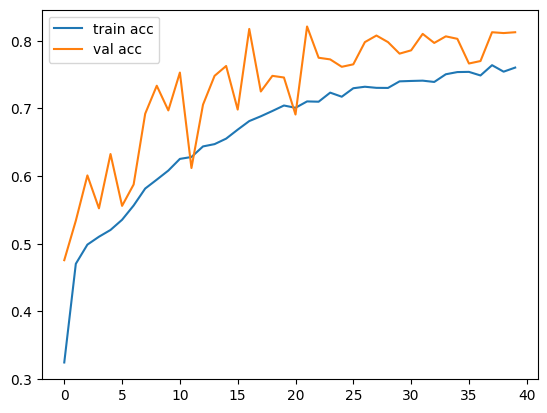

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import cv2

# ------------------------------
# 1. Data Loading + Preprocessing
# ------------------------------
def load_process_image(path, img_size=(128,128)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    img = img.astype('float32') / 255.0
    return np.expand_dims(img, axis=-1)

data_dir = "/kaggle/input/spectograms"
classes = sorted(os.listdir(data_dir))
num_classes = len(classes)

X, y = [], []
for idx, cls in enumerate(classes):
    folder = os.path.join(data_dir, cls)
    for fname in os.listdir(folder):
        fpath = os.path.join(folder, fname)
        X.append(load_process_image(fpath))
        y.append(idx)

X = np.array(X)
y = np.array(y)

print("Original dataset:", {cls: sum(y==i) for i,cls in enumerate(classes)})

# ------------------------------
# 2. Split into Train / Val / Test
# ------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))

# ------------------------------
# 3. Balancing on Train only
# ------------------------------
X_train_flat = X_train.reshape((X_train.shape[0], -1))
ros = RandomOverSampler(sampling_strategy="auto", random_state=42)
X_res, y_res = ros.fit_resample(X_train_flat, y_train)
X_train_balanced = X_res.reshape((-1,128,128,1))
y_train_balanced = y_res

print("Balanced train:", {cls: sum(y_train_balanced==i) for i,cls in enumerate(classes)})

# Convert to one-hot
y_train_oh = to_categorical(y_train_balanced, num_classes=num_classes)
y_val_oh = to_categorical(y_val, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

# ------------------------------
# 4. Data augmentation
# ------------------------------
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train_balanced)

# ------------------------------
# 5. K-means clustering
# ------------------------------
n_clusters = 3
X_flat = X_train_balanced.reshape((X_train_balanced.shape[0], -1))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_flat)

y_cluster_train = to_categorical(clusters, num_classes=n_clusters)
y_cluster_val = np.zeros((len(X_val), n_clusters))
y_cluster_test = np.zeros((len(X_test), n_clusters))

# ------------------------------
# 6. Build CNN
# ------------------------------
def build_clustered_cnn(input_shape=(128,128,1), num_classes=num_classes, n_clusters=n_clusters):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)

    class_out = layers.Dense(num_classes, activation='softmax', name="class")(x)
    cluster_out = layers.Dense(n_clusters, activation='softmax', name="cluster")(x)

    return Model(inputs=inputs, outputs=[class_out, cluster_out])

model = build_clustered_cnn()
model.summary()

# ------------------------------
# 7. Compile
# ------------------------------
losses = {
    "class": "categorical_crossentropy",
    "cluster": "categorical_crossentropy"
}
loss_weights = {"class": 1.0, "cluster": 0.3}

model.compile(optimizer="adam", loss=losses, loss_weights=loss_weights, metrics={"class": "accuracy"})

# ------------------------------
# 8. Training pipeline with augmentation + clusters
# ------------------------------
train_gen = datagen.flow(X_train_balanced, y_train_oh, batch_size=32)

def gen():
    for batch_x, batch_y_class in train_gen:
        idx = np.random.choice(len(y_cluster_train), size=batch_x.shape[0])
        batch_y_cluster = y_cluster_train[idx]
        yield batch_x, {"class": batch_y_class, "cluster": batch_y_cluster}

train_dataset = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(None,128,128,1), dtype=tf.float32),
        {
            "class": tf.TensorSpec(shape=(None,num_classes), dtype=tf.float32),
            "cluster": tf.TensorSpec(shape=(None,n_clusters), dtype=tf.float32),
        }
    )
)

history = model.fit(
    train_dataset,
    validation_data=(X_val, {"class": y_val_oh, "cluster": y_cluster_val}),
    epochs=40,
    steps_per_epoch=len(X_train_balanced)//32
)

# ------------------------------
# 9. Evaluate
# ------------------------------
y_pred_class, _ = model.predict(X_test)
y_true_labels = np.argmax(y_test_oh, axis=1)
y_pred_labels = np.argmax(y_pred_class, axis=1)

print("\nClassification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=classes))
print("\nConfusion Matrix:\n", confusion_matrix(y_true_labels, y_pred_labels))

# ------------------------------
# 10. Plot Training Curves
# ------------------------------
plt.plot(history.history["class_accuracy"], label="train acc")
plt.plot(history.history["val_class_accuracy"], label="val acc")
plt.legend()
plt.show()


Class distribution before balancing: {'Empty Pot': 1036, 'Greenhouse Noises': 1378, 'Tobacco Cut': 506, 'Tobacco Dry': 275, 'Tomato Cut': 660, 'Tomato Dry': 1622}
Train: 3833 Val: 822 Test: 822
Class distribution after balancing: {'Empty Pot': 1135, 'Greenhouse Noises': 1135, 'Tobacco Cut': 1135, 'Tobacco Dry': 1135, 'Tomato Cut': 1135, 'Tomato Dry': 1135}


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 32)   │            320 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 64, 64, 32)     │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 32, 32, 64)     │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 16, 16, 128)    │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 8, 8, 256)      │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 16384)          │              0 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 16384)          │              0 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class (Dense)             │ (None, 6)              │         98,310 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cluster (Dense)           │ (None, 3)              │         49,155 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 535,305 (2.04 MB)

 Trainable params: 535,305 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
212/212 ━━━━━━━━━━━━━━━━━━━━ 141s 651ms/step - class_accuracy: 0.2738 - class_loss: 1.6487 - class_precision: 0.6247 - class_recall: 0.0556 - cluster_loss: 0.3082 - loss: 1.9569 - val_class_accuracy: 0.5633 - val_class_loss: 1.0551 - val_class_precision: 0.8978 - val_class_recall: 0.3528 - val_cluster_loss: 0.0000e+00 - val_loss: 1.0543
Epoch 2/40
212/212 ━━━━━━━━━━━━━━━━━━━━ 138s 653ms/step - class_accuracy: 0.4750 - class_loss: 1.2231 - class_precision: 0.8561 - class_recall: 0.2697 - cluster_loss: 0.3085 - loss: 1.5321 - val_class_accuracy: 0.6521 - val_class_loss: 0.8597 - val_class_precision: 0.9306 - val_class_recall: 0.4075 - val_cluster_loss: 0.0000e+00 - val_loss: 0.8606
Epoch 3/40
212/212 ━━━━━━━━━━━━━━━━━━━━ 139s 657ms/step - class_accuracy: 0.4799 - class_loss: 1.1224 - class_precision: 0.8984 - class_recall: 0.2827 - cluster_loss: 0.3073 - loss: 1.4290 - val_class_accuracy: 0.5572 - val_class_loss: 0.8379 - val_class_precision: 0.9381 - val_class_recall: 0.4428 

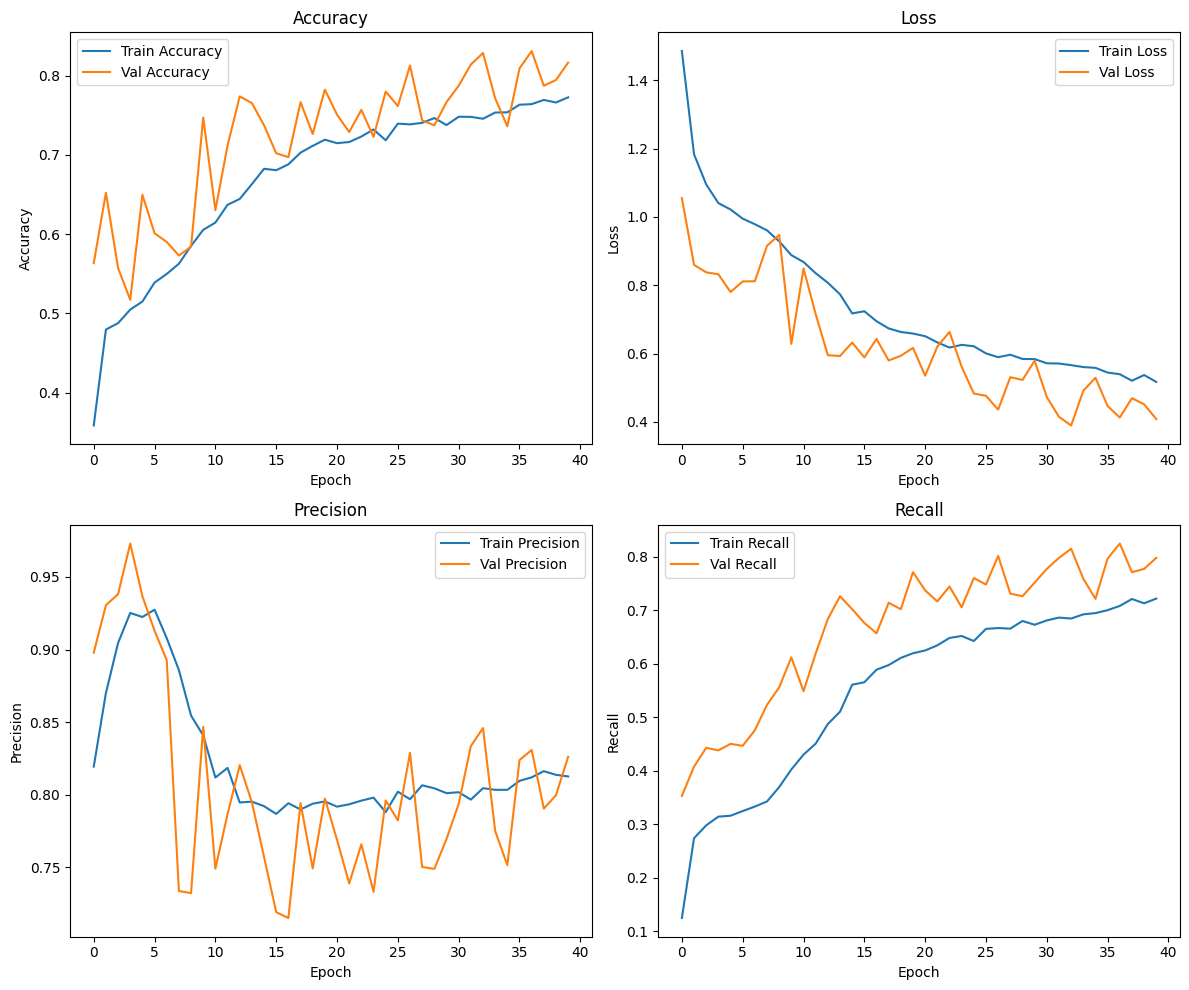

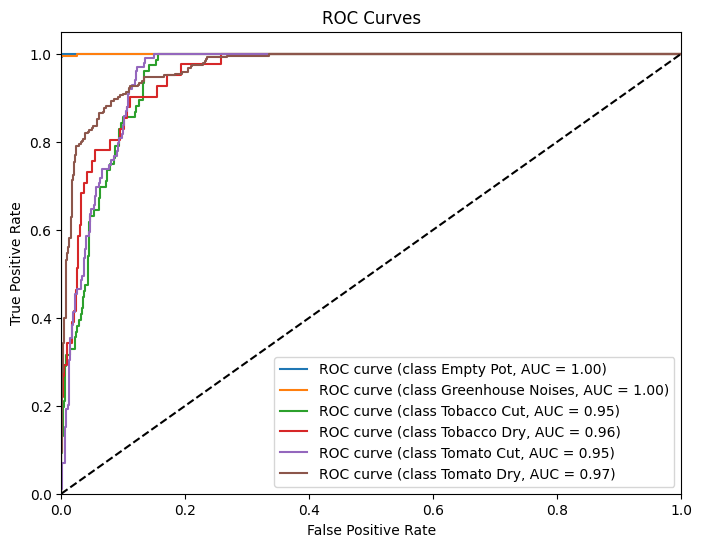

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import cv2

# ------------------------------
# 1. Data Loading + Preprocessing
# ------------------------------
def load_process_image(path, img_size=(128,128)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    img = img.astype('float32') / 255.0
    return np.expand_dims(img, axis=-1)

data_dir = "/kaggle/input/spectograms"
classes = sorted(os.listdir(data_dir))
num_classes = len(classes)

X, y = [], []
for idx, cls in enumerate(classes):
    folder = os.path.join(data_dir, cls)
    for fname in os.listdir(folder):
        fpath = os.path.join(folder, fname)
        X.append(load_process_image(fpath))
        y.append(idx)

X = np.array(X)
y = np.array(y)

print("Class distribution before balancing:", {cls: sum(y==i) for i,cls in enumerate(classes)})

# ------------------------------
# 2. Split into Train / Val / Test
# ------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))

# ------------------------------
# 3. Balancing on Train only
# ------------------------------
X_train_flat = X_train.reshape((X_train.shape[0], -1))
ros = RandomOverSampler(sampling_strategy="auto", random_state=42)
X_res, y_res = ros.fit_resample(X_train_flat, y_train)
X_train_balanced = X_res.reshape((-1,128,128,1))
y_train_balanced = y_res

print("Class distribution after balancing:", {cls: sum(y_train_balanced==i) for i,cls in enumerate(classes)})

# Convert to one-hot
y_train_oh = to_categorical(y_train_balanced, num_classes=num_classes)
y_val_oh = to_categorical(y_val, num_classes=num_classes)
y_test_oh = to_categorical(y_test, num_classes=num_classes)

# ------------------------------
# 4. Data augmentation
# ------------------------------
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train_balanced)

# ------------------------------
# 5. K-means clustering
# ------------------------------
n_clusters = 3
X_flat = X_train_balanced.reshape((X_train_balanced.shape[0], -1))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_flat)

y_cluster_train = to_categorical(clusters, num_classes=n_clusters)
y_cluster_val = np.zeros((len(X_val), n_clusters))
y_cluster_test = np.zeros((len(X_test), n_clusters))

# ------------------------------
# 6. Build CNN
# ------------------------------
def build_clustered_cnn(input_shape=(128,128,1), num_classes=num_classes, n_clusters=n_clusters):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)

    class_out = layers.Dense(num_classes, activation='softmax', name="class")(x)
    cluster_out = layers.Dense(n_clusters, activation='softmax', name="cluster")(x)

    return Model(inputs=inputs, outputs=[class_out, cluster_out])

model = build_clustered_cnn()
model.summary()

# ------------------------------
# 7. Compile with additional metrics
# ------------------------------
losses = {
    "class": "categorical_crossentropy",
    "cluster": "categorical_crossentropy"
}
loss_weights = {"class": 1.0, "cluster": 0.3}

model.compile(
    optimizer="adam",
    loss=losses,
    loss_weights=loss_weights,
    metrics={
        "class": ["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
    }
)

# ------------------------------
# 8. Training pipeline with augmentation + clusters
# ------------------------------
train_gen = datagen.flow(X_train_balanced, y_train_oh, batch_size=32)

def gen():
    for batch_x, batch_y_class in train_gen:
        idx = np.random.choice(len(y_cluster_train), size=batch_x.shape[0])
        batch_y_cluster = y_cluster_train[idx]
        yield batch_x, {"class": batch_y_class, "cluster": batch_y_cluster}

train_dataset = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(None,128,128,1), dtype=tf.float32),
        {
            "class": tf.TensorSpec(shape=(None,num_classes), dtype=tf.float32),
            "cluster": tf.TensorSpec(shape=(None,n_clusters), dtype=tf.float32),
        }
    )
)

history = model.fit(
    train_dataset,
    validation_data=(X_val, {"class": y_val_oh, "cluster": y_cluster_val}),
    epochs=40,
    steps_per_epoch=len(X_train_balanced)//32
)

# ------------------------------
# 9. Evaluate
# ------------------------------
y_pred_class, _ = model.predict(X_test)
y_true_labels = np.argmax(y_test_oh, axis=1)
y_pred_labels = np.argmax(y_pred_class, axis=1)

print("\nClassification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=classes))
print("\nConfusion Matrix:\n", confusion_matrix(y_true_labels, y_pred_labels))

# ------------------------------
# 10. Plot Training Curves and ROC
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot Accuracy
axes[0, 0].plot(history.history["class_accuracy"], label="Train Accuracy")
axes[0, 0].plot(history.history["val_class_accuracy"], label="Val Accuracy")
axes[0, 0].set_title("Accuracy")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend()

# Plot Loss
axes[0, 1].plot(history.history["class_loss"], label="Train Loss")
axes[0, 1].plot(history.history["val_class_loss"], label="Val Loss")
axes[0, 1].set_title("Loss")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Plot Precision
axes[1, 0].plot(history.history["class_precision"], label="Train Precision")
axes[1, 0].plot(history.history["val_class_precision"], label="Val Precision")
axes[1, 0].set_title("Precision")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Precision")
axes[1, 0].legend()

# Plot Recall
axes[1, 1].plot(history.history["class_recall"], label="Train Recall")
axes[1, 1].plot(history.history["val_class_recall"], label="Val Recall")
axes[1, 1].set_title("Recall")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Recall")
axes[1, 1].legend()

plt.tight_layout()

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_oh[:, i], y_pred_class[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (class {classes[i]}, AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

# Display plots
plt.show()

In [4]:
import os
save_dir = "/kaggle/working/plots"
os.makedirs(save_dir, exist_ok=True)

# Accuracy
plt.figure()
plt.plot(history.history["class_accuracy"], label="Train Accuracy")
plt.plot(history.history["val_class_accuracy"], label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(save_dir, "accuracy.png"))
plt.close()

# Loss
plt.figure()
plt.plot(history.history["class_loss"], label="Train Loss")
plt.plot(history.history["val_class_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(save_dir, "loss.png"))
plt.close()

# Precision
plt.figure()
plt.plot(history.history["class_precision"], label="Train Precision")
plt.plot(history.history["val_class_precision"], label="Val Precision")
plt.title("Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()
plt.savefig(os.path.join(save_dir, "precision.png"))
plt.close()

# Recall
plt.figure()
plt.plot(history.history["class_recall"], label="Train Recall")
plt.plot(history.history["val_class_recall"], label="Val Recall")
plt.title("Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.savefig(os.path.join(save_dir, "recall.png"))
plt.close()


In [5]:
plt.figure(figsize=(8,6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_oh[:, i], y_pred_class[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (class {classes[i]}, AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.savefig(os.path.join(save_dir, "roc_curves.png"))
plt.close()


In [6]:
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10,8))
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
plt.close()


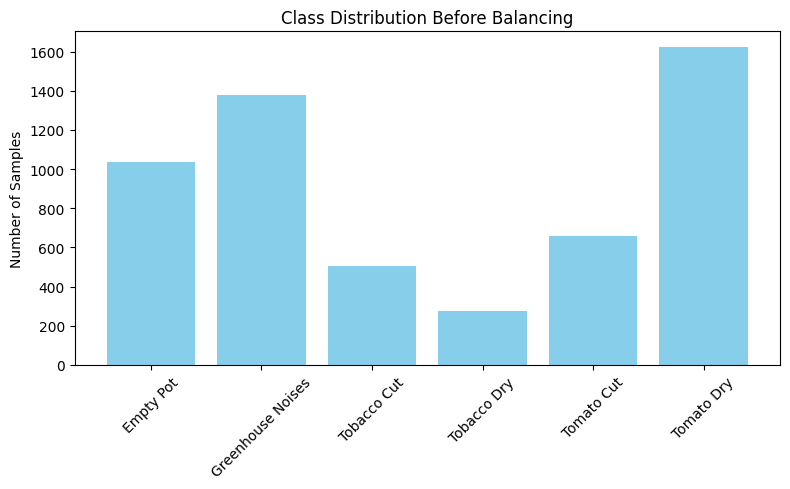

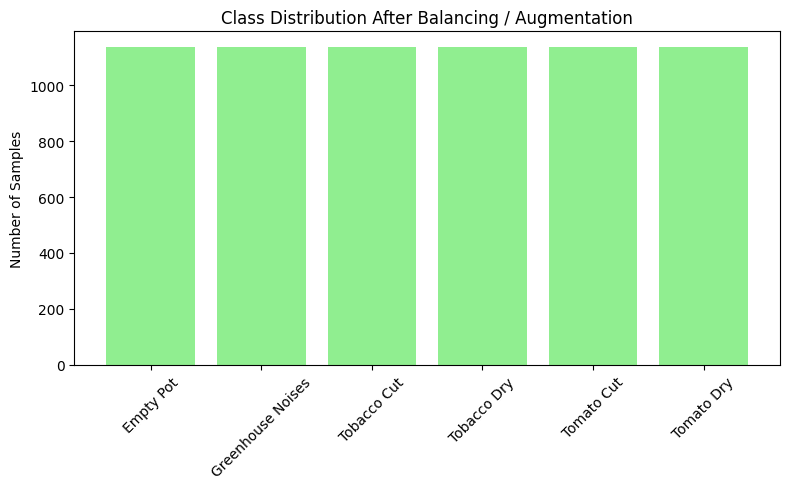

In [7]:
import matplotlib.pyplot as plt

counts_before = [sum(y==i) for i in range(num_classes)]

plt.figure(figsize=(8,5))
plt.bar(classes, counts_before, color='skyblue')
plt.title("Class Distribution Before Balancing")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "class_distribution_before.png"))
plt.show()
counts_after = [sum(y_train_balanced==i) for i in range(num_classes)]

plt.figure(figsize=(8,5))
plt.bar(classes, counts_after, color='lightgreen')
plt.title("Class Distribution After Balancing / Augmentation")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "class_distribution_after.png"))
plt.show()


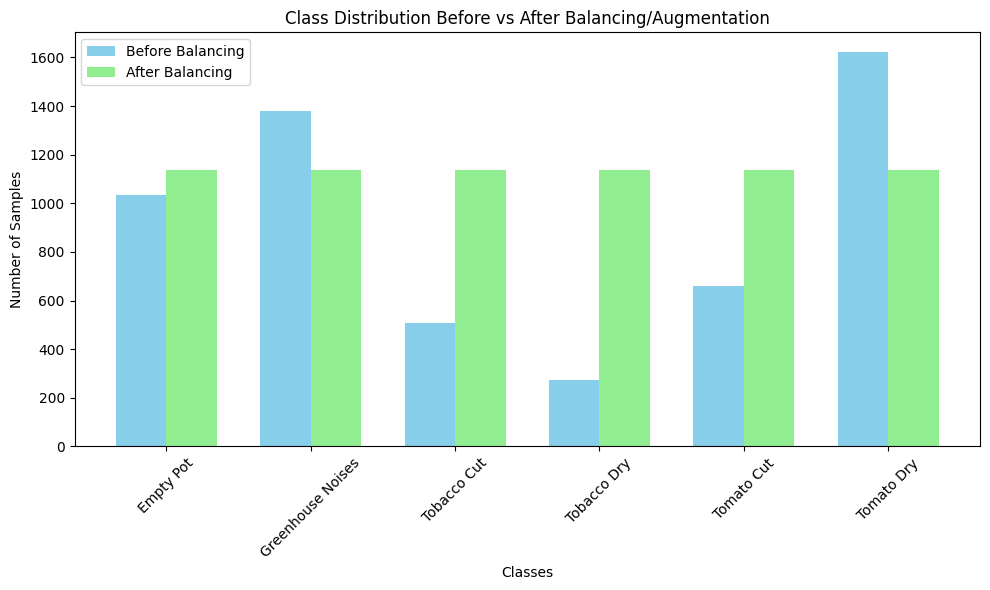

In [8]:
import matplotlib.pyplot as plt
import numpy as np

save_dir = "/kaggle/working"  # change if needed

counts_before = [sum(y==i) for i in range(num_classes)]
counts_after = [sum(y_train_balanced==i) for i in range(num_classes)]

x = np.arange(len(classes))  # label locations
width = 0.35  # width of the bars

plt.figure(figsize=(10,6))
plt.bar(x - width/2, counts_before, width, label='Before Balancing', color='skyblue')
plt.bar(x + width/2, counts_after, width, label='After Balancing', color='lightgreen')

plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution Before vs After Balancing/Augmentation")
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "class_distribution_comparison.png"))
plt.show()


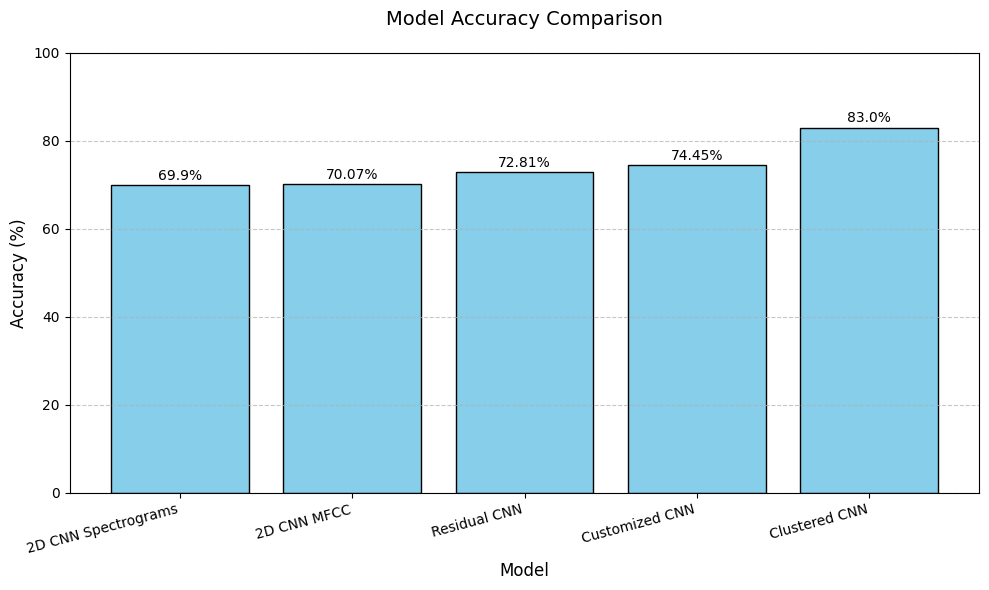

In [9]:
import matplotlib.pyplot as plt

# Data
models = [
    "2D CNN Spectrograms",
    "2D CNN MFCC",
    "Residual CNN",
    "Customized CNN",
    "Clustered CNN"
]
accuracies = [69.9, 70.07, 72.81, 74.45, 83]

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color='skyblue', edgecolor='black')

# Add accuracy values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval}%', ha='center', va='bottom')

# Customize plot
plt.title('Model Accuracy Comparison', fontsize=14, pad=20)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 100)  # Set y-axis limit for better visualization
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15, ha='right')  # Rotate x-axis labels for readability

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "comparison.png"))
# Show plot
plt.show()

new code after augmenting spliting 